# Navigation

---

## DRL-Value-Based-Methods-Navigation
Deep Learning agent that navigate in a virtual world and collect as many yellow bananas as possible while avoiding blue bananas in a large, square world. 

<img src="https://s3.amazonaws.com/video.udacity-data.com/topher/2018/June/5b1ab4b0_banana/banana.gif" alt="" width="400px" class="index--image--1wh9w">

### Project Overview  
For this project, I trained an agent to navigate (and collect bananas!) in a large, square world.

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:  


<ul>
<li><strong><code>0</code></strong> - move forward.</li>
<li><strong><code>1</code></strong> - move backward.</li>
<li><strong><code>2</code></strong> - turn left.</li>
<li><strong><code>3</code></strong> - turn right.</li>
</ul>

The task is episodic, and in order to solve the environment, The agent get an average score of +13 over 100 consecutive episodes.


### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [12]:
import gym
!pip3 install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from dqn_agent import Agent

%matplotlib inline

!python -m pip install unityagents
!python -m pip install pyvirtualdisplay

from unityagents import UnityEnvironment
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

    100% |████████████████████████████████| 112kB 3.2MB/s ta 0:00:01


In [5]:
# please do not modify the line below


visible_environment = False # set this parameter

if visible_environment == True:
    env = UnityEnvironment(file_name='/data/Banana_Linux/Banana.x86_64')
else:
    env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

### 3. Take Random Actions in the Environment

This is the score of non-trained agent who take random actions


Note that in this coding environment, you will not be able to watch the agent while it is training, and you should set `train_mode=True` to restart the environment.


In [ ]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

### 4. Train the Agent with DQN


#### The Model: DQN with experience replay. Based on paper: Human-level control through deep reinforcement learning (https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).



<img src="https://uc085a3cd654c8b046efb77cf6af.previews.dropboxusercontent.com/p/thumb/AAfLsvyFA6xrUWFKnR73TN1SGMmf67qMyaXC0bC0vXmxgOa3XOJAhE0cvMxlw9O04Bmz5isSkSb2pnwHMTtTQqDR-L_vmEWQchmh_SEsZJX4aBxTc_8lGuiqVZaHChQMnKw9MgEZypTNqfzvme2B9acsnDJid998lTJhG85JGGicHeKNo2gj0rQUnia0RXSoBruXKy6McOBZIUKn8ZSHxUC1KP-jUoUkdUn-PXlSp5QA9XHVEAG1sbcSVQeI_bAD_-kWWLQ-OuQMK0ek_WB3OyHiw7SDA19Kg-MtFH--DfPTcxWeWGxOmZxNCG1RixI5ZlJSfXnPxreCXlC6QOPM99tKrRtPIC9gZReqzJLQ-2bK_ge3TDf5U39PjpwYh8sAmjo5irvNAqn0sydlbkCMnm3W3UXs63XtKLudURkhwo5CVaTsGoczaRdkdAf18TTbQ9mNX9vi8FYQ9CUElgM0qOGZ/p.png?fv_content=true&size_mode=5" alt="" width="600px" class="index--image--1wh9w">

Source: Udacity https://www.youtube.com/watch?time_continue=180&v=MqTXoCxQ_eY

The DQN algo use a technique known as experience replay in which we store the agent’s experiences at each time-step, et = (st, at,rt,st + 1), in a data set Dt = {e1,…,et}, pooled over many episodes (where the end of an episode occurs when a terminal state is reached) into a replay memory. During the inner loop of the algorithm, it apply Q-learning updates, or minibatch updates, to samples of experience, (s,a,r,s’) ~ U(D), drawn at random from the pool of stored samples.  

This approach has several advantages over standard online Q-learning.  

- First, each step of experience is potentially used in many weight updates, which allows for greater data efficiency.  
    
- Second, learning directly from consecutive samples is inefficient, owing to the strong correlations between the samples; randomizing the samples breaks these correlations and therefore reduces the variance of the updates.  
    
- Third, when learning on policy the current parameters determine the next data sample that the parameters are trained on. For example, if the maximizing action is to move left then the training samples will be dominated by samples from the left-hand side; if the maximizing action then switches to the right then the training distribution will also switch. It is easy to see how unwanted feedback loops may arise and the parameters could get stuck in a poor local minimum, or even diverge catastrophically. By using experience replay the behaviour distribution is averaged over many of its previous states, smoothing out learning and avoiding oscillations or divergence in the parameters.  

Note that when learning by experience replay, it is necessary to learn off-policy (because our current parameters are different to those used to generate the sample), which motivates the choice of Q-learning.  

In practice, the algorithm only stores the last N experience tuples in the replay memory, and samples uniformly at random from D when performing updates. This approach is in some respects limited because the memory buffer does not differentiate important transitions and always overwrites with recent transitions owing to the finite memory size N. Similarly, the uniform sampling gives equal importance to all transitions in the replay memory. A more sophisticated sampling strategy might emphasize transitions from which we can learn the most, similar to prioritized sweeping.  

DQN use a separate network for generating the targets yj in the Q-learning update to improve the stability of the results. More precisely, every C updates it clone the network Q to obtain a target network Q̇ and use Q̇ for generating the Q-learning targets yj for the following C updates to Q. This modification makes the algorithm more stable compared to standard online Q-learning, where an update that increases Q(st,at) often also increases Q(st+1, a) for all a and hence also increases the target yj, possibly leading to oscillations or divergence of the policy. Generating the targets using an older set of parameters adds a delay between the time an update to Q is made and the time the update affects the targets yj , making divergence or oscillations much more unlikely.


#### The Agent
The agent is trained using a Deep Learning Agent with experience replay buffer. The input are initialize with:  

- n_episodes (2000): maximum number of training episodes  
- max_t (1000): maximum number of timesteps per episode  
- eps_start (1.0): starting value of epsilon, for epsilon-greedy action selection  
- eps_end (0.1): minimum value of epsilon to go and explore  
- eps_decay (0.995): multiplicative factor (per episode) for decreasing epsilon    
- consecutive_episodes = 100  
- target_avg_score = 13.01

At the end the algo find a policy that has a score greater than 13 gained in 475 train episodes

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!


Episode 100	Average Score: 0.86
Episode 200	Average Score: 3.89
Episode 300	Average Score: 7.34
Episode 400	Average Score: 9.64
Episode 500	Average Score: 12.38
Episode 575	Average Score: 13.02
Environment solved in 475 episodes!	Average Score: 13.02


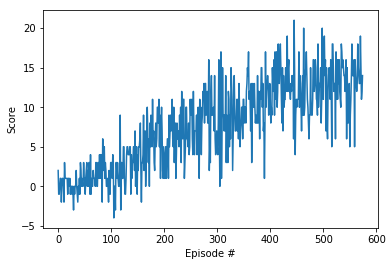

In [6]:
agent = Agent(state_size=37, action_size=4, seed=0)



def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995,
        consecutive_episodes = 100, target_avg_score = 13.01):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen = consecutive_episodes)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]  
            next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=target_avg_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5.Test Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [10]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

agent =  Agent(state_size=37, action_size=4, seed=0)

agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', map_location=map_location))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0.01)                # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0


In [ ]:
env.close()

### Ideas for Future Work

I would like to implement Rainbow approach based on the paper: Rainbow: Combining Improvements in Deep Reinforcement Learning https://arxiv.org/pdf/1710.02298.pdf

Example of the implementation: https://github.com/Kaixhin/Rainbow

This summary of the methodology if found on: https://hollygrimm.com/rl_dqn

#### Rainbow takes the standard DQN algorithm and adds the following features:

#### Prioritized Experience Replay
Replaying all transitions from the replay buffer with equal probability is wasteful. It's better to prioritize the data sampled from the buffer using the absolute Bellman error where the predicted reward diverges greatly from the expected reward. In addition, more recent transitions have a higher priority. 

#### Double DQN (DDQN)
The estimated Q values from the Neural Network are often overestimated. When you calculate the target value, it's based on the highest valued action for a state. Updating the Q network with these values will keep amplifying the Q values.

Since we already have two networks, the Q network and Target network, you can use the Q network (φ) to select the best action using argmax, and then the Target network (φ') to get the value estimate. This decorrelates the noise and avoids amplification.

#### Dueling DQN
The advantage value is the difference between the Q(s, a) value and the state value V(s). For an action it's measuring how much worse an action is in comparison to the best action in a state.

With Dueling DQN, you change the architecture of the neural network by splitting it into two separate estimators after convolution.  The first estimator is the state value V(s), a single number. The second estimator outputs one number per action, the advantages. To calculate the Q values, the advantage is summed with the state value and the average value of the advantages is subtracted.

#### Noisy Nets for Exploration
Add noise to network parameters for better exploration

#### N-step Q-Learning
When calculating the target value in Q-Learning, the target value is based on only the current reward. For N-step Q-Learning, rewards from N steps are added together and the Q function value is added only at the very end.

#### Distributional RL
Takes a single output reward value and replaces it with a distribution of rewards across N values. For the paper, they used 51 bins and called the algorithm C51.

